# Initialize

## ASW session

In [1]:
import boto3

session = boto3.Session()
s3 = session.resource('s3')

## SageMaker Session

In [2]:
import sagemaker

sage_session = sagemaker.Session()

# Define Globals

In [72]:
# bucket name
bucket = 'aida-project'

# path for s3_input
s3_path = f"s3://{bucket}/"

## define source files
# TRAIN source file
train_source_path = 'team_remote'
train_source_name = 'title-train.csv'
#train_source_name = 'title-valid.csv'       # for testing; remove later


# VALID source file
valid_source_path = 'team_remote'
valid_source_name = 'title-valid.csv'
#valid_source_name = 'title-test.csv'       # for testing; remove later

# TEST source file
test_source_path = 'team_remote'
test_source_name = 'title-test.csv'

# output for result
output_path =''
output_location = f'{s3_path}{output_path}/output'

In [ ]:
print(output_location)

In [73]:
# Create pointers to the S3 train and test datasets

from sagemaker import s3_input

# print(f"{s3_path}{train_source_path}/{train_source_name}")
# print(f"{s3_path}{valid_source_path}/{valid_source_name}")
# print(f"{s3_path}{test_source_path}/{test_source_name}")
s3_input_train = sagemaker.session.s3_input(s3_data=f"{s3_path}{train_source_path}/{train_source_name}", content_type="text/csv")
s3_input_valid = sagemaker.session.s3_input(s3_data=f"{s3_path}{valid_source_path}/{valid_source_name}", content_type="text/csv")
s3_input_test = sagemaker.session.s3_input(s3_data=f"{s3_path}{test_source_path}/{test_source_name}", content_type="text/csv")

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [5]:
role = sagemaker.get_execution_role()

# Define Model

In [26]:
# finde pre-defined models here:
# https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html

# Create an XGBoost Estimator

# estimator call
# <ecr_path>/sagemaker-xgboost:1.2-1
    
ecr_path = "492215442770.dkr.ecr.eu-central-1.amazonaws.com"
xgboost_estimator = f"{ecr_path}/sagemaker-xgboost:1.0-1-cpu-py3"

# ecr_path = "664544806723.dkr.ecr.eu-central-1.amazonaws.com"
# knn_estimator = f"{ecr_path}/knn:latest"


In [27]:
xgboost = sagemaker.estimator.Estimator(xgboost_estimator,
                              role,
                              train_instance_count=1,
                              train_instance_type="ml.m5.4xlarge",
                              output_path=output_location,
                              sagemaker_session=sage_session,
                              base_job_name="JPC-xgboost")

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [74]:
# Select the your specific hyperparameters (Optional)
# https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst#learning-task-parameters 

xgboost.set_hyperparameters(
    eta=.35,
    num_round=50,                     # required parameter!
    objective = 'reg:linear',
    )

## Fit Model

In [ ]:
xgboost.fit({"train": s3_input_train, "validation": s3_input_valid}, wait=True)

2020-11-18 14:16:02 Starting - Starting the training job...

# Deploy Model

## Deploy

In [32]:
# Deploy  model to an endpoint

xgb_predictor = xgboost.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

## Configure Predictor

In [33]:
# Configure the predictor's serializer and deserializer

# INSERT CODE HERE

from sagemaker.predictor import csv_serializer, json_deserializer

xgb_predictor.content_type = "text/csv"
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = json_deserializer

# Display Endpoint

In [34]:
xgb_predictor.endpoint

'JPC-xgboost-2020-11-18-13-09-41-058'

# Prediction

[7.140199661254883, 7.1985344886779785, 4.231838703155518, 5.891756534576416, 6.8615312576293945, 5.698119640350342, 5.2546515464782715, 5.865857124328613, 6.94377326965332, 6.711339950561523, 6.642725467681885, 5.799829006195068, 5.97669792175293, 6.777210712432861, 5.292905330657959, 6.1847920417785645, 7.164303779602051, 5.332376480102539, 3.8829874992370605, 7.0364909172058105, 7.658117294311523, 7.394268989562988, 2.972052574157715, 3.712526559829712, 6.7953290939331055, 5.896793842315674, 6.493631839752197, 5.2562360763549805, 4.575633525848389, 6.971129417419434, 6.937532424926758, 6.106511116027832, 6.360768795013428, 5.544117450714111, 6.018372535705566, 6.07960844039917, 7.032017707824707, 3.6609978675842285, 6.890119552612305, 6.233912467956543, 5.760210037231445, 6.571094512939453, 4.1832275390625, 5.711309432983398, 4.070681571960449, 5.783310890197754, 6.036551475524902, 7.169101715087891, 4.966709136962891, 6.690051078796387, 5.816529750823975, 5.740322589874268, 6.81459

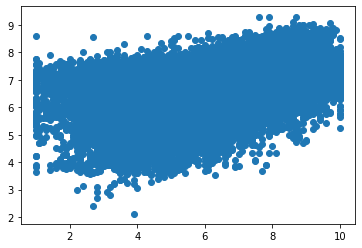

In [54]:
# carefully just one prediction
import pandas as pd
import matplotlib.pyplot as plt

col_names = ['averageRating', 'isAdult', 'startYear', 'endYear', 'numVotes', 'Crime', 'Romance', 'Thriller', 'Adventure', 'Drama', 'War', 'Documentary', 'Reality-TV', 'Family', 'Fantasy', 'Game-Show', 'Adult', 'History', 'Mystery', 'Musical', 'Animation', 'Music', 'Film-Noir', 'shortGenre', 'Horror', 'Western', 'Biography', 'Comedy', 'Action', 'Sport', 'Talk-Show', 'Sci-Fi', 'News', 'movie', 'short', 'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvShort', 'tvSpecial', 'video', 'videoGame', 'distinct languages', 'distinct regions']
test = pd.read_csv(f"{s3_path}{test_source_path}/{test_source_name}", header=0, index_col=False, names=col_names)
prediction=[]
for i in range(test.shape[0]):
    prediction.append(xgb_predictor.predict(test.iloc[i, 1:]))
    #     print(prediction)
    #     print(test.iloc[i,0])
#print(prediction) 

plt.scatter(test.iloc[:,0], prediction)


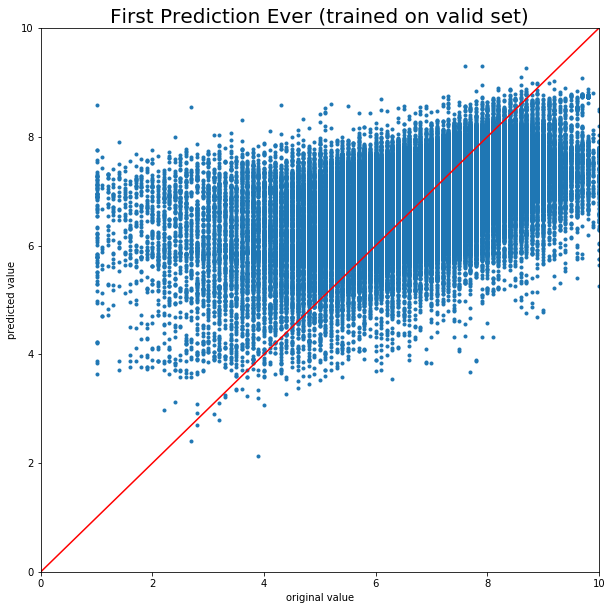

In [71]:
fig = plt.subplots(figsize=(10,10))
plt.scatter(test.iloc[:,0], prediction,marker='.')
plt.title('First Prediction Ever (trained on valid set)', fontsize=20)
plt.xlabel('original value')
plt.ylabel('predicted value')
plt.xlim([0,10])
plt.ylim([0,10])
plt.plot([0,10],[0,10], c='red')

#plt.show()

plt.savefig('firstPrediction', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait')
